### Setup

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from collections import defaultdict
import json

from src.utils.reproducibility import set_seed, print_system_info
from src.utils.visualization import (
    plot_class_distribution,
    plot_image_properties,
    plot_sample_grid,
    print_summary_statistics
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

set_seed(42)

### Definir Paths y Datos

In [2]:
# Define paths
DATA_DIR = Path('../data/raw/chest_xray')
SPLIT_FILE = Path('../data/raw/train_val_split.json')
REPORTS_DIR = Path('../reports/figures')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Verify data exists
if not DATA_DIR.exists():
    print("ERROR: Dataset not found!")
    print(f"   Expected location: {DATA_DIR}")
    print("\n   Please run: python src/data/download.py")
else:
    print(f"Dataset found: {DATA_DIR}")

if not SPLIT_FILE.exists():
    print("ERROR: Split file not found!")
    print(f"   Expected location: {SPLIT_FILE}")
else:
    print(f"Split file found: {SPLIT_FILE}")

# List directory structure
print("\nDirectory structure:")
for split in ['train', 'val', 'test']:
    split_dir = DATA_DIR / split
    if split_dir.exists():
        print(f"   ├── {split}/")
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = split_dir / class_name
            if class_dir.exists():
                n_files = len(list(class_dir.glob('*.jpeg')))
                print(f"   │   ├── {class_name}/ ({n_files} images)")


Dataset found: ../data/raw/chest_xray
Split file found: ../data/raw/train_val_split.json

Directory structure:
   ├── train/
   │   ├── NORMAL/ (1341 images)
   │   ├── PNEUMONIA/ (3875 images)
   ├── val/
   │   ├── NORMAL/ (8 images)
   │   ├── PNEUMONIA/ (8 images)
   ├── test/
   │   ├── NORMAL/ (234 images)
   │   ├── PNEUMONIA/ (390 images)


In [4]:
def count_images_in_split(data_dir, split):
    """Count images in a split (original structure)"""
    counts = {}
    split_dir = data_dir / split
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = split_dir / class_name
        if class_dir.exists():
            counts[class_name] = len(list(class_dir.glob('*.jpeg')))
        else:
            counts[class_name] = 0
    
    return counts

# Count images in original splits
print("\n" + "="*70)
print("IMAGE COUNTS - ORIGINAL KAGGLE SPLITS")
print("="*70 + "\n")

original_counts = {}
for split in ['train', 'val', 'test']:
    counts = count_images_in_split(DATA_DIR, split)
    original_counts[split] = counts
    total = sum(counts.values())
    print(f"{split.upper():5s} | NORMAL: {counts['NORMAL']:4d} | "
          f"PNEUMONIA: {counts['PNEUMONIA']:4d} | TOTAL: {total:4d}")

# Calculate totals
total_normal = sum(c['NORMAL'] for c in original_counts.values())
total_pneumonia = sum(c['PNEUMONIA'] for c in original_counts.values())
grand_total = total_normal + total_pneumonia

print(f"\n{'TOTAL':5s} | NORMAL: {total_normal:4d} | "
      f"PNEUMONIA: {total_pneumonia:4d} | TOTAL: {grand_total:4d}")
print(f"\nClass ratio (PNEUMONIA:NORMAL): {total_pneumonia/total_normal:.2f}:1")
print(f"Class imbalance: PNEUMONIA = {total_pneumonia/grand_total*100:.1f}%")



IMAGE COUNTS - ORIGINAL KAGGLE SPLITS

TRAIN | NORMAL: 1341 | PNEUMONIA: 3875 | TOTAL: 5216
VAL   | NORMAL:    8 | PNEUMONIA:    8 | TOTAL:   16
TEST  | NORMAL:  234 | PNEUMONIA:  390 | TOTAL:  624

TOTAL | NORMAL: 1583 | PNEUMONIA: 4273 | TOTAL: 5856

Class ratio (PNEUMONIA:NORMAL): 2.70:1
Class imbalance: PNEUMONIA = 73.0%


In [5]:
# Load custom train/val split - Balance the splits
print("\n" + "="*70)
print("IMAGE COUNTS - CUSTOM BALANCED SPLIT")
print("="*70 + "\n")

with open(SPLIT_FILE) as f:
    split_info = json.load(f)

# Count custom splits
custom_counts = {
    'train': {
        'NORMAL': len(split_info['train_normal']),
        'PNEUMONIA': len(split_info['train_pneumonia'])
    },
    'val': {
        'NORMAL': len(split_info['val_normal']),
        'PNEUMONIA': len(split_info['val_pneumonia'])
    },
    'test': original_counts['test']  # Test unchanged
}

for split in ['train', 'val', 'test']:
    counts = custom_counts[split]
    total = sum(counts.values())
    ratio = counts['PNEUMONIA'] / counts['NORMAL']
    print(f"{split.upper():5s} | NORMAL: {counts['NORMAL']:4d} | "
          f"PNEUMONIA: {counts['PNEUMONIA']:4d} | TOTAL: {total:4d} | "
          f"Ratio: {ratio:.2f}:1")


IMAGE COUNTS - CUSTOM BALANCED SPLIT

TRAIN | NORMAL: 1139 | PNEUMONIA: 3293 | TOTAL: 4432 | Ratio: 2.89:1
VAL   | NORMAL:  202 | PNEUMONIA:  582 | TOTAL:  784 | Ratio: 2.88:1
TEST  | NORMAL:  234 | PNEUMONIA:  390 | TOTAL:  624 | Ratio: 1.67:1


✅ Figure saved to: ../reports/figures/01_class_distribution.png


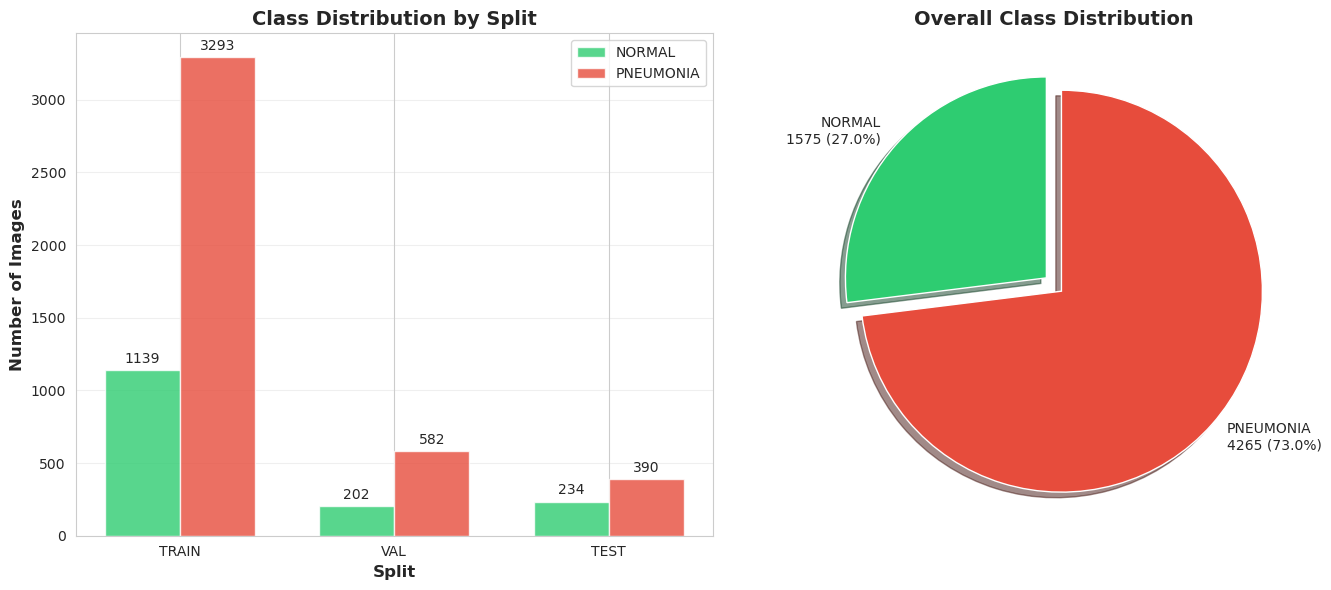

In [6]:
# Plot class distribution
fig = plot_class_distribution(
    custom_counts,
    save_path='../reports/figures/01_class_distribution.png',
    figsize=(14, 6)
)


In [7]:
def analyze_image_properties(image_paths, n_samples=200, seed=42):
    """Analyze properties of a set of images"""
    np.random.seed(seed)
    
    # Sample images if too many
    if len(image_paths) > n_samples:
        image_paths = np.random.choice(image_paths, n_samples, replace=False)
    
    stats = {
        'widths': [],
        'heights': [],
        'means': [],
        'stds': [],
        'mins': [],
        'maxs': []
    }
    
    print(f"   Analyzing {len(image_paths)} images...")
    
    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            h, w = img.shape
            stats['widths'].append(w)
            stats['heights'].append(h)
            stats['means'].append(img.mean())
            stats['stds'].append(img.std())
            stats['mins'].append(img.min())
            stats['maxs'].append(img.max())
    
    return stats

# Collect image paths
print("\n" + "="*70)
print("ANALYZING IMAGE PROPERTIES")
print("="*70 + "\n")

train_dir = DATA_DIR / 'train'
normal_paths = list((train_dir / 'NORMAL').glob('*.jpeg'))
pneumonia_paths = list((train_dir / 'PNEUMONIA').glob('*.jpeg'))

print(f"Found {len(normal_paths)} NORMAL images")
print(f"Found {len(pneumonia_paths)} PNEUMONIA images")
print("\nAnalyzing samples (200 per class)...\n")

# Analyze both classes
print("NORMAL class:")
normal_stats = analyze_image_properties(normal_paths, n_samples=200)

print("\nPNEUMONIA class:")
pneumonia_stats = analyze_image_properties(pneumonia_paths, n_samples=200)

# Combine for plotting
all_stats = {
    'NORMAL': normal_stats,
    'PNEUMONIA': pneumonia_stats
}



ANALYZING IMAGE PROPERTIES

Found 1341 NORMAL images
Found 3875 PNEUMONIA images

Analyzing samples (200 per class)...

NORMAL class:
   Analyzing 200 images...

PNEUMONIA class:
   Analyzing 200 images...


In [8]:
# Print summary statistics
print_summary_statistics(all_stats)



IMAGE STATISTICS SUMMARY

📊 NORMAL Class:
--------------------------------------------------
  Width:  min=1098, max=2890, mean=1675.0, std=302.1
  Height: min=885, max=2625, mean=1390.5, std=342.1
  Intensity Mean: min=83.8, max=168.4, avg=124.0
  Intensity Std:  min=40.9, max=83.1, avg=61.3

📊 PNEUMONIA Class:
--------------------------------------------------
  Width:  min=384, max=2072, mean=1203.9, std=272.5
  Height: min=127, max=2104, mean=823.0, std=263.7
  Intensity Mean: min=73.4, max=165.3, avg=123.4
  Intensity Std:  min=29.4, max=83.9, avg=55.8




✅ Figure saved to: ../reports/figures/02_image_properties.png


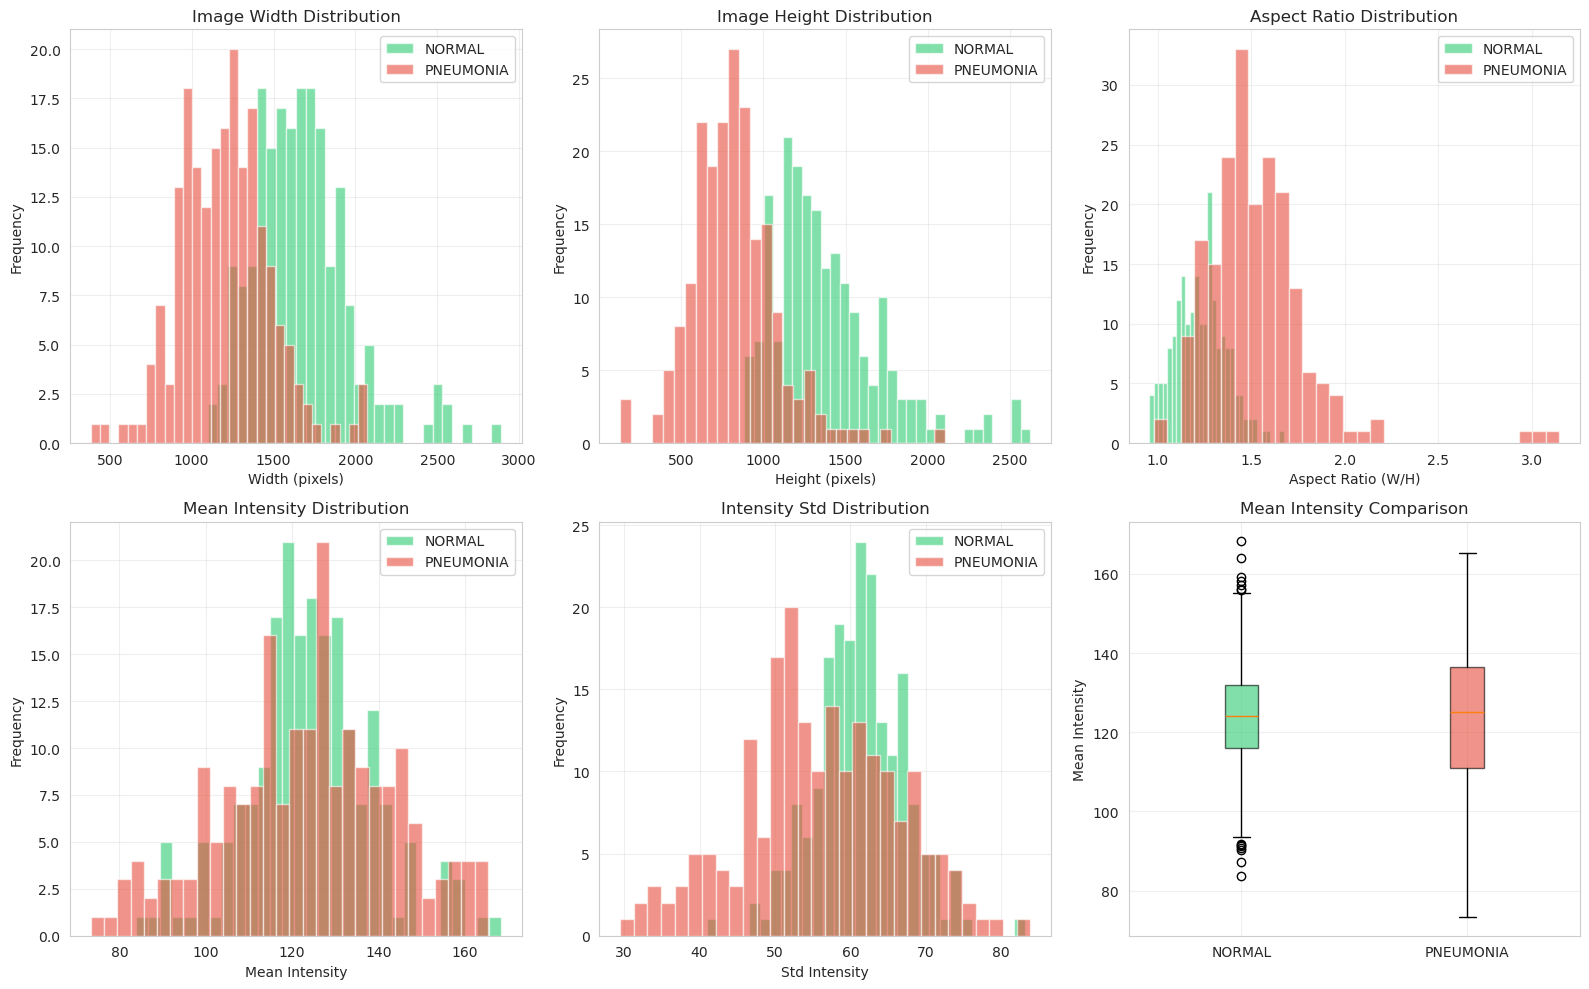

In [9]:
# Plot image properties

fig = plot_image_properties(
    all_stats,
    save_path='../reports/figures/02_image_properties.png',
    figsize=(16, 10)
)


✅ Figure saved to: ../reports/figures/03_sample_images.png


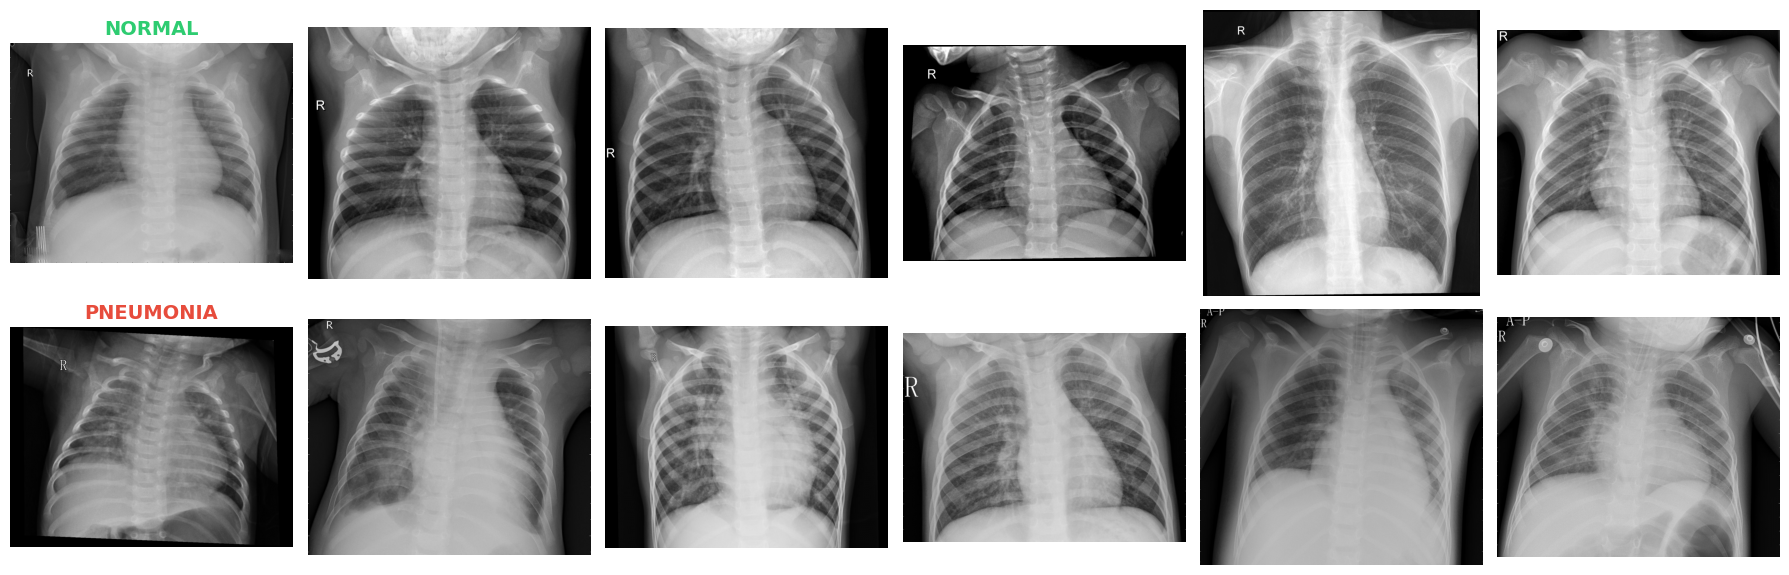

In [10]:
# Plot sample grid

fig = plot_sample_grid(
    normal_paths,
    pneumonia_paths,
    n_samples=6,
    seed=42,
    save_path='../reports/figures/03_sample_images.png',
    figsize=(18, 6)
)
